<a href="https://colab.research.google.com/github/LuisNietoM/AsignacionDeCartera/blob/main/An%C3%A1lisis_Factorial_Perdida_de_Energ%C3%ADa_en_la_Distribuci%C3%B3n_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
#@title Configuración

# Instalación de las bibliotecas necesarias
!pip install mapclassify --quiet
!pip install factor_analyzer --quiet

# Importación de las bibliotecas
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import folium
import geopandas as gpd
import seaborn as sns
import networkx as nx
from factor_analyzer import FactorAnalyzer
from IPython.display import display, Latex, Markdown

from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from scipy.stats import bartlett

import warnings
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

# Montaje de Google Drive para acceder a los archivos
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Definición de constantes
CARPETA = "/content/drive/MyDrive/ENSA/Análisis de perdida"
INPUT = "dataset_20240415.txt"

# Carga del DataFrame desde el archivo CSV
url = os.path.join(CARPETA, INPUT)
df = pd.read_csv(url, index_col="Id Transformador")
df = df[df['Perdida Total Por'] >= 0.6]

Mounted at /content/drive


# Análisis Factorial de Perdidas en la Distribución de Energía Eléctrica


El Análisis Factorial (AF) es una técnica estadística utilizada para identificar patrones subyacentes entre un conjunto de variables observadas. En el contexto de las pérdidas en la distribución de energía eléctrica, el AF puede ayudar a desentrañar las relaciones complejas entre diferentes factores que podrían contribuir a estas pérdidas.


El objetivo de este análisis es investigar las causas detrás de las pérdidas de energía en la distribución. Mediante el uso del AF, buscamos identificar patrones y relaciones entre diferentes variables que podrían estar contribuyendo a estas pérdidas.


In [74]:
#@title Variables

display(Markdown(f"#### Las variables utilizadas en este análisis son las siguientes:"))
for col in df.columns:
    display(Markdown(f"* {col}"))

#### Las variables utilizadas en este análisis son las siguientes:

* Perdida Total Por

* Instalaciones Facturadas

* Qtd Ucs Facturables

* Pendientes por facturar

* Energía de Entrada (Lectura del Elemento)

* Consumo Facturado

* Consumo AP (Alumbrado Público)

* Energía de Salida (total de las salidas)

* Latitud

* Longitud

* Total de NACs

* Total de clientes cortados

* Total clientes ZR

* Total de clientes PP

* Antiguedad media

* Total de cortes generados

* Total de cortes efectivos

* Total de inspecciones al cortado

* Total de visitas por inspección generadas

* Consumo total (H + M)

* Consumo total promedio (13M)

* Consumo total mensual

* Consumo total horario

* Consumo total horario bajo

* Consumo total horario medio

* Demanda total media mensual (13M)

* Demanda total mensual

* Demanda total horaria

* Demanda total horaria baja

* Demanda total horaria media

* Score medio

* Prob Asociada media

* Dias medios desde ultimo pago

* Pago total medio mensual

* % De Clientes Comercio e Indust.

* % De Clientes Residenciales

* % De Clientes de otras categorías

* ATD_CUR

* ATD_CURA

* ATD_CURD

* ATH

* ATH_CUR

* BTD

* BTD_CUR

* BTH

* BTH_CUR

* BTS

* BTS_CF

* BTS_PE

* BTS_PP_001

* BTS_PP_002

* BTS_PP_005

* BTS_PP_006

* MTD

* MTD_CUR

* MTH

* MTH_CUR

* Area Rural Concentrada

* Area Rural Dispersa

* Area Rural Muy Dispersa

* Area Sub Urbana

* Area Urbana

* Clientes Mayores

* Corporativo

* Intermedios

* Mayores-Vendedores

* No Regulado

* Normales

* Oxigeno Dependientes

* Sensitivo Comercial

* Sensitivo Residencial

* Temporal

* Vinculado a Grandes Clientes

* 0

* 1

* Aérea

* Subterranea

* Medición directa

* Medición semiindirecta/indirecta

* Menor a 100 KWh

* De 101 a 500 KWh

* De 501 a 1000 KWh

* De 1001 a 5000 KWh

* De 5001 a 10000 KWh

* De 10001 a 20000 KWh

* De 20001 a 50000 KWh

* Mayor a 50001 KWh

* Núm. de Ilegales


Para analizar las pérdidas, se tomó como muestra las pérdidas contabilizadas por los medidores en un periodo de 8 meses, que va de julio del 2023 a febrero del 2024. Cabe resaltar que solo se tomaron los datos de aquellas observaciones que tienen un balance confiable según el departamento de ingeniería y que la pérdida sea mayor a cero, ya que no tiene sentido tener pérdidas positivas. A continuación, se presenta un histograma de las pérdidas porcentuales medias de la muestra.


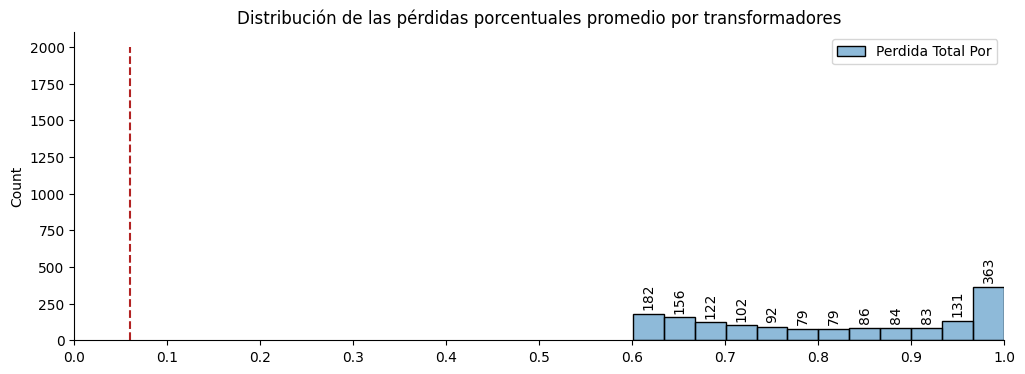


Según un estudio de la Autoridad de los Servicios Públicos (ASEP), las pérdidas en el segmento de distribución deberían variar entre el 5% y el 6%. Sin embargo, en los datos analizados tenemos los siguientes resultados [texto del enlace](https://www.ariae.org/sites/default/files/2017-05/La%20eficiencia%20en%20las%20redes%20niveles%20de%20p%C3%A9rdidas%20y%20reducci%C3%B3n%20de%20fraude%20energ%C3%A9tico.pdf).


Número de observaciones: 1,559

Observaciones con pérdidas por encima del 6%: 1,559

Porcentaje de observaciones con pérdidas por encima del 6%: 100.00%

Promedio del promedio de las pérdidas de energía por transformador: 81.68%

In [75]:
#@title Distribución de las pérdidas porcentuales promedio por transformadores

display(Markdown("""
Para analizar las pérdidas, se tomó como muestra las pérdidas contabilizadas por los medidores en un periodo de 8 meses, que va de julio del 2023 a febrero del 2024. Cabe resaltar que solo se tomaron los datos de aquellas observaciones que tienen un balance confiable según el departamento de ingeniería y que la pérdida sea mayor a cero, ya que no tiene sentido tener pérdidas positivas. A continuación, se presenta un histograma de las pérdidas porcentuales medias de la muestra.
"""))

# Histograma de las pérdidas porcentuales medias
mean = df.groupby("Id Transformador").agg({"Perdida Total Por": "mean"})
fig, ax = plt.subplots(figsize=(12, 4))
sns.histplot(mean, ax=ax)
ax.set_title('Distribución de las pérdidas porcentuales promedio por transformadores')

# Etiquetas para el valor de cada barra
for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 50, f'{int(height)}', rotation=90, ha="center")

# Línea vertical en el 6%
ax.vlines(x=0.06, ymin=0, ymax=2_000, color="firebrick", ls="--", label="0.06")
# ax.vlines(x=np.mean(mean.values), ymin=0, ymax=2_000, color="firebrick", ls="--", label=f"{np.mean(mean.values):.2f}")
ax.set_xlim(0, 1)
ax.set_xticks(np.arange(0, 1.1, 0.1))
sns.despine()
plt.show()

# Número de observaciones
num_obs = mean.shape[0]

# Pérdidas mayores al 6%
pred_mas_6_por = mean[mean["Perdida Total Por"] > 0.06].shape[0]

# Porcentaje de observaciones por encima del 6%
por_mas_6_por = pred_mas_6_por / num_obs

display(Markdown("""
Según un estudio de la Autoridad de los Servicios Públicos (ASEP), las pérdidas en el segmento de distribución deberían variar entre el 5% y el 6%. Sin embargo, en los datos analizados tenemos los siguientes resultados [texto del enlace](https://www.ariae.org/sites/default/files/2017-05/La%20eficiencia%20en%20las%20redes%20niveles%20de%20p%C3%A9rdidas%20y%20reducci%C3%B3n%20de%20fraude%20energ%C3%A9tico.pdf).
"""))
display(Markdown(f"Número de observaciones: {num_obs:,}"))
display(Markdown(f"Observaciones con pérdidas por encima del 6%: {pred_mas_6_por:,}"))
display(Markdown(f"Porcentaje de observaciones con pérdidas por encima del 6%: {por_mas_6_por:.2%}"))
display(Markdown(f"Promedio del promedio de las pérdidas de energía por transformador: {np.mean(mean.values):.2%}"))



In [76]:
#@title Prepocesamiento de datos: Imputación, estandarización y escalamiento

texto = """
En esta sección, realizaremos el preprocesamiento de datos, que incluye la imputación de valores faltantes, la estandarización y el escalado de las variables numéricas.

### Imputación de valores faltantes
Para abordar los valores faltantes en nuestro conjunto de datos, utilizaremos la mediana como estrategia de imputación. La mediana es una medida robusta que es menos sensible a los valores atípicos y puede proporcionar una mejor estimación de los valores faltantes en comparación con la media.

### Estandarización
La estandarización es un paso importante en el preprocesamiento de datos que transforma las variables numéricas para que tengan una media de 0 y una desviación estándar de 1. Esto ayuda a que las características tengan la misma escala, lo que puede mejorar el rendimiento de muchos algoritmos de aprendizaje automático.

La fórmula para estandarizar una variable \(X\) es:
"""
display(Markdown(texto))
display(Latex("$$X_{\t{estandarizado}} = \dfrac{X - \mu}{\sigma}$$"))

texto_escalamiento = """
### Escalamiento
El escalado de características es otra técnica utilizada para llevar todas las variables a un rango común. En este caso, utilizaremos el escalado Min-Max, que transforma los datos para que estén en un rango de 0 a 1. Esto preserva la estructura relativa de los datos y es útil cuando se desea mantener la interpretación de las unidades originales de las variables.

La fórmula para escalar una variable \(X\) usando el escalado Min-Max es:
"""
display(Markdown(texto_escalamiento))
display(Latex("$$X_{\t{escalado}} = \dfrac{X - X_{\t{mínimo}}}{X_{\t{máximo}} - X_{\t{mínimo}}}$$"))

print("\n")

columnas_numericas = df.select_dtypes(include=['number'])
pipe = make_pipeline(SimpleImputer(strategy="median"), StandardScaler(), MinMaxScaler())
X = pipe.fit_transform(columnas_numericas)

index=columnas_numericas.index
columns=columnas_numericas.columns
new_df = pd.DataFrame(X, index=index, columns=columns)
new_df



En esta sección, realizaremos el preprocesamiento de datos, que incluye la imputación de valores faltantes, la estandarización y el escalado de las variables numéricas.

### Imputación de valores faltantes
Para abordar los valores faltantes en nuestro conjunto de datos, utilizaremos la mediana como estrategia de imputación. La mediana es una medida robusta que es menos sensible a los valores atípicos y puede proporcionar una mejor estimación de los valores faltantes en comparación con la media.

### Estandarización
La estandarización es un paso importante en el preprocesamiento de datos que transforma las variables numéricas para que tengan una media de 0 y una desviación estándar de 1. Esto ayuda a que las características tengan la misma escala, lo que puede mejorar el rendimiento de muchos algoritmos de aprendizaje automático.

La fórmula para estandarizar una variable \(X\) es:


<IPython.core.display.Latex object>


### Escalamiento
El escalado de características es otra técnica utilizada para llevar todas las variables a un rango común. En este caso, utilizaremos el escalado Min-Max, que transforma los datos para que estén en un rango de 0 a 1. Esto preserva la estructura relativa de los datos y es útil cuando se desea mantener la interpretación de las unidades originales de las variables.

La fórmula para escalar una variable \(X\) usando el escalado Min-Max es:


<IPython.core.display.Latex object>

,Perdida Total Por,Instalaciones Facturadas,Qtd Ucs Facturables,Pendientes por facturar,Energía de Entrada (Lectura del Elemento),Consumo Facturado,Consumo AP (Alumbrado Público),Energía de Salida (total de las salidas),Latitud,Longitud,...,Medición semiindirecta/indirecta,Menor a 100 KWh,De 101 a 500 KWh,De 501 a 1000 KWh,De 1001 a 5000 KWh,De 5001 a 10000 KWh,De 10001 a 20000 KWh,De 20001 a 50000 KWh,Mayor a 50001 KWh,Núm. de Ilegales
Id Transformador,,,,,,,,,,,,,,,,,,,,,
ENSA1010220,0.019873,0.426407,0.294643,0.036713,0.526314,0.548481,0.108894,0.573267,0.422819,0.361499,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333
ENSA1010241,0.840304,0.012987,0.008929,0.034965,0.312731,0.031699,0.086084,0.055665,0.423919,0.363252,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333
ENSA1010255,0.470865,0.064935,0.044643,0.034965,0.114946,0.064391,0.015372,0.068032,0.424892,0.363855,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333
ENSA1010261,0.330653,0.038961,0.026786,0.034965,0.086691,0.059153,0.023058,0.065021,0.424134,0.364676,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333
ENSA1010263,0.599022,0.090909,0.062500,0.034965,0.176593,0.067190,0.044579,0.079049,0.423519,0.364513,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSA84000113,0.448422,0.064935,0.044643,0.034965,0.190507,0.118547,0.000000,0.117257,0.710757,0.180208,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333
ENSA84000135,0.596146,0.220779,0.169643,0.055944,0.257025,0.126724,0.000000,0.125345,0.724035,0.189900,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333
ENSA91200018,0.049249,0.272727,0.187500,0.034965,0.257701,0.262243,0.045636,0.272278,0.000000,1.000000,...,0.333333,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.083333


In [77]:
new_df.columns

Index(['Perdida Total Por', 'Instalaciones Facturadas', 'Qtd Ucs Facturables',
       'Pendientes por facturar', 'Energía de Entrada (Lectura del Elemento)',
       'Consumo Facturado', 'Consumo AP (Alumbrado Público)',
       'Energía de Salida (total de las salidas)', 'Latitud', 'Longitud',
       'Total de NACs', 'Total de clientes cortados', 'Total clientes ZR',
       'Total de clientes PP', 'Antiguedad media', 'Total de cortes generados',
       'Total de cortes efectivos', 'Total de inspecciones al cortado',
       'Total de visitas por inspección generadas', 'Consumo total (H + M)',
       'Consumo total promedio (13M)', 'Consumo total mensual',
       'Consumo total horario', 'Consumo total horario bajo',
       'Consumo total horario medio', 'Demanda total media mensual (13M)',
       'Demanda total mensual', 'Demanda total horaria',
       'Demanda total horaria baja', 'Demanda total horaria media',
       'Score medio', 'Prob Asociada media', 'Dias medios desde ultimo pago'

In [78]:
columns = [
    'ATD_CUR', 'ATD_CURA', 'ATD_CURD', 'ATH', 'ATH_CUR', 'BTD', 'BTD_CUR',
    'BTH', 'BTH_CUR', 'BTS', 'BTS_CF', 'BTS_PE', 'BTS_PP_001', 'BTS_PP_002',
    'BTS_PP_005', 'BTS_PP_006', 'MTD', 'MTD_CUR', 'MTH', 'MTH_CUR',
    'Area Rural Concentrada', 'Area Rural Dispersa',
    'Area Rural Muy Dispersa', 'Area Sub Urbana', 'Area Urbana',
    'Clientes Mayores', 'Corporativo', 'Intermedios', 'Mayores-Vendedores',
    'No Regulado', 'Normales', 'Oxigeno Dependientes',
    'Sensitivo Comercial', 'Sensitivo Residencial', 'Temporal',
    'Vinculado a Grandes Clientes', '0', '1',
]

new_df.drop(columns, axis=1, inplace=True)


Este gráfico muestra la distribución de las variables después de aplicar el proceso de normalización.
La normalización es una técnica común en el preprocesamiento de datos, que ajusta los valores de las variables
para que estén dentro de un rango específico, generalmente entre 0 y 1.

En un gráfico de cajas, la línea en el centro de la caja representa la mediana de la distribución,
mientras que la parte inferior y superior de la caja representan el primer y tercer cuartil, respectivamente.
Las líneas que se extienden desde la caja, llamadas "bigotes", muestran la extensión de los datos más allá de los cuartiles.
Los puntos que se encuentran más allá de los bigotes se consideran valores atípicos.

Observar la distribución de las variables normalizadas puede proporcionar información sobre la dispersión de los datos
y la presencia de valores atípicos después del proceso de normalización. Esto es importante para comprender
cómo se comportan las variables en relación con la escala común establecida por la normalización.


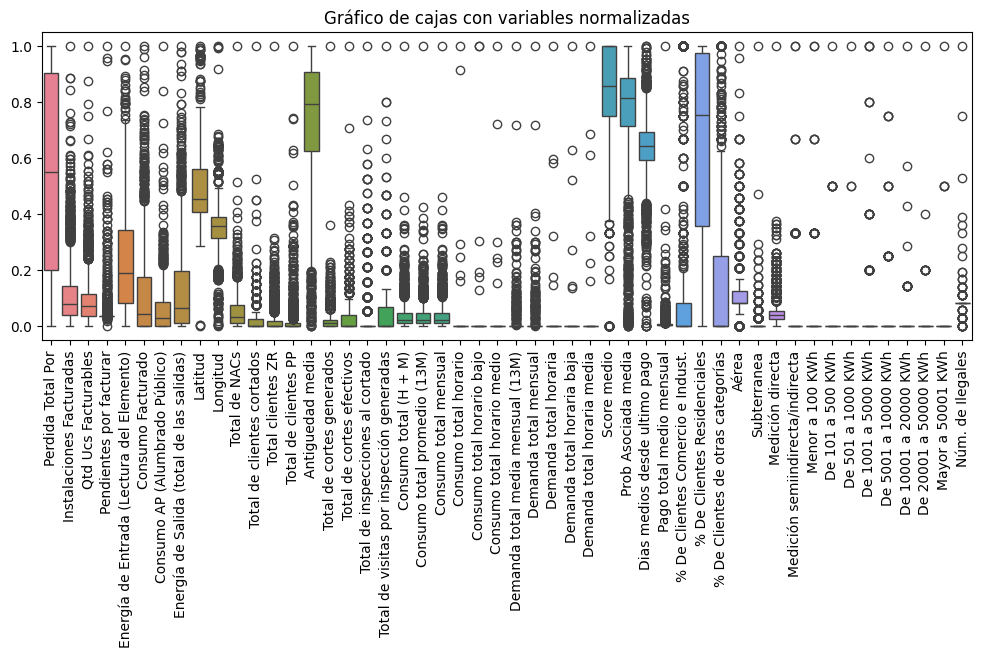

In [79]:
#@title Gráfico de cajas con variables normalizadas

texto_explicativo = """
Este gráfico muestra la distribución de las variables después de aplicar el proceso de normalización.
La normalización es una técnica común en el preprocesamiento de datos, que ajusta los valores de las variables
para que estén dentro de un rango específico, generalmente entre 0 y 1.

En un gráfico de cajas, la línea en el centro de la caja representa la mediana de la distribución,
mientras que la parte inferior y superior de la caja representan el primer y tercer cuartil, respectivamente.
Las líneas que se extienden desde la caja, llamadas "bigotes", muestran la extensión de los datos más allá de los cuartiles.
Los puntos que se encuentran más allá de los bigotes se consideran valores atípicos.

Observar la distribución de las variables normalizadas puede proporcionar información sobre la dispersión de los datos
y la presencia de valores atípicos después del proceso de normalización. Esto es importante para comprender
cómo se comportan las variables en relación con la escala común establecida por la normalización.
"""

display(Markdown(texto_explicativo))

fig, ax = plt.subplots(figsize=(12, 4))
sns.boxplot(new_df, ax=ax)
plt.xticks(rotation=90)
plt.title('Gráfico de cajas con variables normalizadas')  # Agregar título al gráfico
plt.show()


In [80]:
#@title Buscar variables redundantes

# Matriz de correlación
matrix_corr = new_df.corr(numeric_only=True, method="pearson")

# Define un umbral de correlación
umbral_correlacion = 0.95

# Crea una lista para almacenar las variables redundantes
variables_redundantes = []

# Itera sobre las columnas de la matriz de correlación
for i in range(len(matrix_corr.columns)):
    for j in range(i+1, len(matrix_corr.columns)):
        correlacion = matrix_corr.iloc[i, j]
        # Si la correlación entre dos variables es mayor que el umbral, añádelas a la lista de variables redundantes
        if abs(correlacion) > umbral_correlacion:
            variables_redundantes.append((matrix_corr.columns[i], matrix_corr.columns[j], correlacion))

# Crear la tabla Markdown como una cadena de texto
tabla_markdown = "#### Variables redundantes\n"
tabla_markdown += "| Var1 | Var2 | Corr |\n"
tabla_markdown += "|------|------|------|\n"
for var1, var2, corr in variables_redundantes:
    tabla_markdown += f"| {var1} | {var2} | {corr:.0%} |\n"

# Mostrar la tabla Markdown
display(Markdown(tabla_markdown))

#### Variables redundantes
| Var1 | Var2 | Corr |
|------|------|------|
| Consumo Facturado | Energía de Salida (total de las salidas) | 99% |
| Consumo total (H + M) | Consumo total promedio (13M) | 99% |
| Consumo total (H + M) | Consumo total mensual | 100% |
| Consumo total promedio (13M) | Consumo total mensual | 99% |
| Consumo total horario | Consumo total horario bajo | 100% |
| Consumo total horario | Consumo total horario medio | 98% |
| Consumo total horario bajo | Consumo total horario medio | 98% |
| Consumo total horario medio | Demanda total horaria | 97% |
| Consumo total horario medio | Demanda total horaria baja | 95% |
| Consumo total horario medio | Demanda total horaria media | 95% |
| Demanda total media mensual (13M) | Demanda total mensual | 98% |
| Demanda total horaria | Demanda total horaria baja | 100% |
| Demanda total horaria | Demanda total horaria media | 100% |
| Demanda total horaria baja | Demanda total horaria media | 100% |


In [81]:
#@title variables a eliminar

variables_eliminar = []
for var1, var2, corr in variables_redundantes:
    variables_eliminar.append(var1)

variables_eliminar = list(set(variables_eliminar))
for i in variables_eliminar:
    display(Markdown(f"* {i}"))

new_df = new_df.drop(variables_eliminar, axis=1)

* Consumo total horario bajo

* Demanda total horaria baja

* Consumo Facturado

* Consumo total horario medio

* Demanda total media mensual (13M)

* Consumo total promedio (13M)

* Demanda total horaria

* Consumo total (H + M)

* Consumo total horario


Este mapa de calor muestra la correlación de Pearson entre la variable específica 'Perdida Total Por' y todas las demás variables del conjunto de datos después del proceso de normalización.

La correlación de Pearson es una medida de la relación lineal entre dos variables continuas, que oscila entre -1 y 1.
Un valor de 1 indica una correlación positiva perfecta, -1 indica una correlación negativa perfecta,
y 0 indica la ausencia de correlación lineal.

En el mapa de calor, los valores más cercanos a 1 (color rojo) indican una fuerte correlación positiva con la variable específica,
mientras que los valores cercanos a -1 (color azul) indican una fuerte correlación negativa.
Los valores cercanos a 0 (color blanco) sugieren una correlación débil o nula.

Observar la correlación de Pearson puede proporcionar información sobre la relación lineal entre la variable específica
y otras variables del conjunto de datos, lo que puede ser útil para identificar posibles predictores o variables relacionadas.


<IPython.core.display.Latex object>

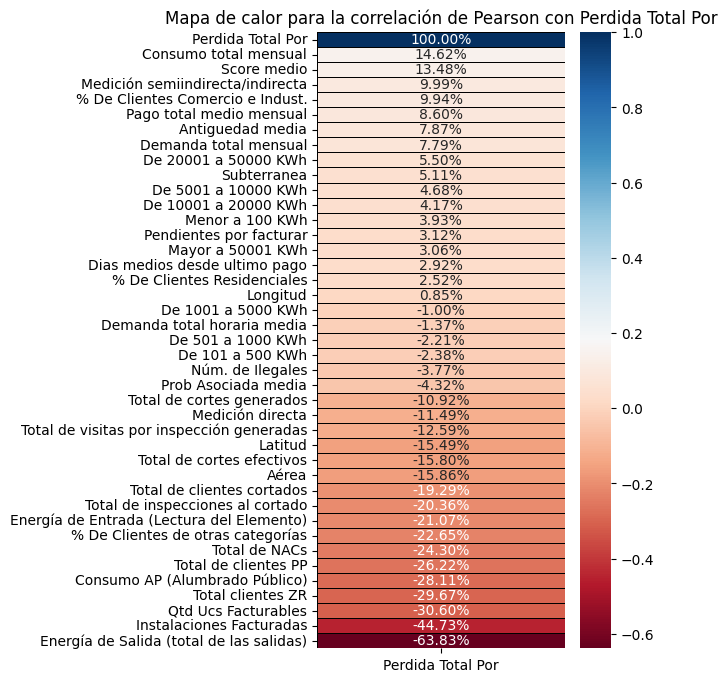

In [82]:
#@title Mapa de calor para la correlación de Pearson: Perdida Total Por

texto_explicativo = """
Este mapa de calor muestra la correlación de Pearson entre la variable específica 'Perdida Total Por' y todas las demás variables del conjunto de datos después del proceso de normalización.

La correlación de Pearson es una medida de la relación lineal entre dos variables continuas, que oscila entre -1 y 1.
Un valor de 1 indica una correlación positiva perfecta, -1 indica una correlación negativa perfecta,
y 0 indica la ausencia de correlación lineal.

En el mapa de calor, los valores más cercanos a 1 (color rojo) indican una fuerte correlación positiva con la variable específica,
mientras que los valores cercanos a -1 (color azul) indican una fuerte correlación negativa.
Los valores cercanos a 0 (color blanco) sugieren una correlación débil o nula.

Observar la correlación de Pearson puede proporcionar información sobre la relación lineal entre la variable específica
y otras variables del conjunto de datos, lo que puede ser útil para identificar posibles predictores o variables relacionadas.
"""

display(Markdown(texto_explicativo))

variable_especifica = 'Perdida Total Por'
matrix_corr = new_df.corr(numeric_only=True, method="pearson")
correlation_with_specific_variable = matrix_corr.loc[variable_especifica].sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(4, 8))
sns.heatmap(
    correlation_with_specific_variable.to_frame(),
    annot=True, fmt=".2%", cmap="RdBu", linewidths=0.5,
    linecolor="k", ax=ax
)

# Mostrando la fórmula del determinante usando LaTeX
formula_latex = r"$$\text{Correlación de Pearson}(X, Y) = \frac{\sum_{i=1}^{n}(X_i - \bar{X})(Y_i - \bar{Y})}{\sqrt{\sum_{i=1}^{n}(X_i - \bar{X})^2} \times \sqrt{\sum_{i=1}^{n}(Y_i - \bar{Y})^2}}$$"
display(Latex(formula_latex))
print("\n")

plt.title(f'Mapa de calor para la correlación de Pearson con {variable_especifica}')
plt.show()



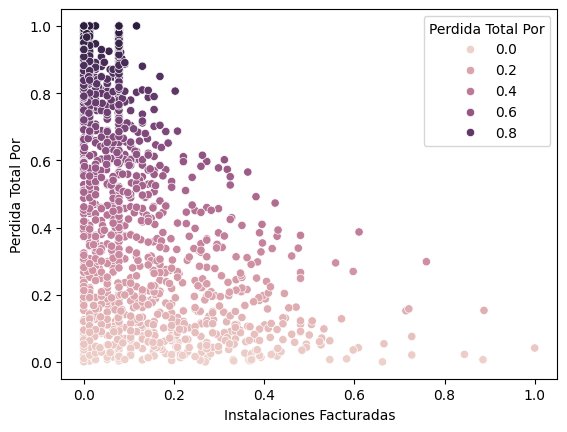

In [83]:
sns.scatterplot(new_df, x="Instalaciones Facturadas", y="Perdida Total Por", hue="Perdida Total Por")
plt.show()

In [84]:
#@title Determinante de la matriz de correlación

texto_explicativo = """
El determinante de una matriz de correlación es una medida de la dependencia lineal entre las variables en el conjunto de datos.
Si el determinante es cercano a cero, indica que las variables están altamente correlacionadas y que existe una dependencia lineal significativa entre ellas.
Por otro lado, si el determinante es significativamente diferente de cero, indica que las variables son independientes o tienen una relación lineal débil.

La fórmula para calcular el determinante de una matriz de correlación es:
"""
display(Markdown(texto_explicativo))

formula_latex = r"$$\text{Determinante}(\text{matriz de correlación}) = \prod_{i=1}^{n} \lambda_i$$"
display(Latex(formula_latex))

texto_explicativo = """
Donde $\lambda_i$ representa los autovalores de la matriz de correlación.

Es importante tener en cuenta el determinante de la matriz de correlación para evaluar la multicolinealidad entre las variables.
La multicolinealidad puede causar problemas en modelos de regresión y otros análisis estadísticos, ya que puede afectar la estabilidad y precisión de las estimaciones.
"""
display(Markdown(texto_explicativo))

# Calculando el determinante de la matriz de correlación
determinante = np.linalg.det(matrix_corr)

# Mostrando la fórmula del determinante usando LaTeX
formula_latex = r"\text{Determinante}(\text{matriz de correlación}) = \prod_{i=1}^{n} \lambda_i=" + f"{determinante:.8f}"
display(Latex(formula_latex))



El determinante de una matriz de correlación es una medida de la dependencia lineal entre las variables en el conjunto de datos.
Si el determinante es cercano a cero, indica que las variables están altamente correlacionadas y que existe una dependencia lineal significativa entre ellas.
Por otro lado, si el determinante es significativamente diferente de cero, indica que las variables son independientes o tienen una relación lineal débil.

La fórmula para calcular el determinante de una matriz de correlación es:


<IPython.core.display.Latex object>


Donde $\lambda_i$ representa los autovalores de la matriz de correlación.

Es importante tener en cuenta el determinante de la matriz de correlación para evaluar la multicolinealidad entre las variables.
La multicolinealidad puede causar problemas en modelos de regresión y otros análisis estadísticos, ya que puede afectar la estabilidad y precisión de las estimaciones.


<IPython.core.display.Latex object>

In [85]:
#@title Prueba de Esfericidad de Bartlett

# Descripción de la prueba de Esfericidad de Bartlett y la fórmula
display(Markdown("""
La prueba de Esfericidad de Bartlett se utiliza para verificar si las correlaciones entre las variables en un conjunto de datos son significativas. Evalúa si la matriz de correlación es una matriz de identidad, lo que implicaría que las variables son no correlacionadas, o si hay alguna correlación significativa entre las variables.

La fórmula para la prueba de Esfericidad de Bartlett es la siguiente:
"""))

# Fórmula de la prueba de Bartlett en LaTeX
display(Latex(r"$$P(\chi^2) = -( (N-1) - \frac{(2k-5)}{6} ) \cdot \ln(det(R))$$"))

# Descripción de los símbolos en la fórmula
display(Markdown("""
Donde:

- $P(X^2)$: es la probabilidad asociada con la distribución chi-cuadrado.
- $N$: es el número total de observaciones.
- $k$: es el número de variables (columnas) en el conjunto de datos.
- $det(R)$: es el determinante de la matriz de correlación entre las variables.
"""))

# Realización de la prueba de Esfericidad de Bartlett para todas las variables excepto la variable de interés
variable_interes = "Perdida Total Por"
columnas_a_analizar = new_df.columns

display(Markdown("#### Prueba de Esfericidad de Bartlett por variable:"))

for col in columnas_a_analizar:
    if col != variable_interes:
        # Combina las dos columnas en un DataFrame
        df_temp = new_df[[variable_interes, col]]
        resultado_bartlett = calculate_bartlett_sphericity(df_temp)
        p_valor_bartlett = resultado_bartlett[1]

        # Aplica formato para cambiar el color del texto si el valor p es mayor a 0.05
        if p_valor_bartlett > 0.05:
            p_valor_formateado = f"<font color='color:red'>{p_valor_bartlett:.8f}</font>"
        else:
            p_valor_formateado = f"{p_valor_bartlett:.8f}"

        display(Markdown(f"P-valor de la prueba de Esfericidad de Bartlett para '{variable_interes}' y '{col}': {p_valor_formateado}"))

_, p_valor = calculate_bartlett_sphericity(df_temp)
display(Markdown("#### Prueba de Esfericidad de Bartlett Total:"))
display(Markdown(f"P-valor de la prueba de Esfericidad de Bartlett: {p_valor: .8f}"))



La prueba de Esfericidad de Bartlett se utiliza para verificar si las correlaciones entre las variables en un conjunto de datos son significativas. Evalúa si la matriz de correlación es una matriz de identidad, lo que implicaría que las variables son no correlacionadas, o si hay alguna correlación significativa entre las variables.

La fórmula para la prueba de Esfericidad de Bartlett es la siguiente:


<IPython.core.display.Latex object>


Donde:

- $P(X^2)$: es la probabilidad asociada con la distribución chi-cuadrado.
- $N$: es el número total de observaciones.
- $k$: es el número de variables (columnas) en el conjunto de datos.
- $det(R)$: es el determinante de la matriz de correlación entre las variables.


#### Prueba de Esfericidad de Bartlett por variable:

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y 'Instalaciones Facturadas': 0.00000000

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y 'Qtd Ucs Facturables': 0.00000000

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y 'Pendientes por facturar': <font color='color:red'>0.21852083</font>

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y 'Energía de Entrada (Lectura del Elemento)': 0.00000000

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y 'Consumo AP (Alumbrado Público)': 0.00000000

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y 'Energía de Salida (total de las salidas)': 0.00000000

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y 'Latitud': 0.00000000

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y 'Longitud': <font color='color:red'>0.73765057</font>

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y 'Total de NACs': 0.00000000

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y 'Total de clientes cortados': 0.00000000

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y 'Total clientes ZR': 0.00000000

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y 'Total de clientes PP': 0.00000000

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y 'Antiguedad media': 0.00187803

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y 'Total de cortes generados': 0.00001555

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y 'Total de cortes efectivos': 0.00000000

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y 'Total de inspecciones al cortado': 0.00000000

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y 'Total de visitas por inspección generadas': 0.00000061

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y 'Consumo total mensual': 0.00000001

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y 'Demanda total mensual': 0.00208027

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y 'Demanda total horaria media': <font color='color:red'>0.58804633</font>

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y 'Score medio': 0.00000009

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y 'Prob Asociada media': <font color='color:red'>0.08780414</font>

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y 'Dias medios desde ultimo pago': <font color='color:red'>0.24994018</font>

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y 'Pago total medio mensual': 0.00067391

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y '% De Clientes Comercio e Indust.': 0.00008491

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y '% De Clientes Residenciales': <font color='color:red'>0.32096902</font>

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y '% De Clientes de otras categorías': 0.00000000

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y 'Aérea': 0.00000000

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y 'Subterranea': 0.04376367

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y 'Medición directa': 0.00000542

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y 'Medición semiindirecta/indirecta': 0.00007761

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y 'Menor a 100 KWh': <font color='color:red'>0.12064154</font>

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y 'De 101 a 500 KWh': <font color='color:red'>0.34702292</font>

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y 'De 501 a 1000 KWh': <font color='color:red'>0.38265794</font>

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y 'De 1001 a 5000 KWh': <font color='color:red'>0.69428200</font>

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y 'De 5001 a 10000 KWh': <font color='color:red'>0.06490353</font>

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y 'De 10001 a 20000 KWh': <font color='color:red'>0.09970886</font>

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y 'De 20001 a 50000 KWh': 0.02997169

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y 'Mayor a 50001 KWh': <font color='color:red'>0.22782055</font>

P-valor de la prueba de Esfericidad de Bartlett para 'Perdida Total Por' y 'Núm. de Ilegales': <font color='color:red'>0.13695789</font>

#### Prueba de Esfericidad de Bartlett Total:

P-valor de la prueba de Esfericidad de Bartlett:  0.13695789

In [86]:
#@title Criterio de Kaiser-Meyer-Olkin (KMO)
from factor_analyzer.factor_analyzer import calculate_kmo

# Descripción del Criterio de Kaiser-Meyer-Olkin (KMO)
display(Markdown("""
El Criterio de Kaiser-Meyer-Olkin (KMO) se utiliza para evaluar si los datos son adecuados para realizar un análisis factorial.
Proporciona una medida de la adecuación de los datos para el análisis factorial, donde valores más altos indican que los datos son más adecuados para este propósito.
Un valor KMO superior a 0.6 se considera aceptable para proceder con el análisis factorial.

La fórmula para calcular el KMO es:
"""))

# Fórmula del KMO en LaTeX
display(Latex(r"$$KMO = \frac{\sum_{i}^{p}(\sum_{j}^{p} r_{ij}^2) - \sum_{i}^{p}\sum_{j}^{p} r_{ij}^2}{\sum_{i}^{p}(\sum_{j}^{p} r_{ij}^2) + \sum_{i}^{p}\sum_{j}^{p} r_{ij}^2}$$"))

display(Markdown("""
Donde:
- $KMO$: es el índice de Kaiser-Meyer-Olkin.
- $r_{ij}$: son los coeficientes de correlación parcial entre todas las variables.
- $p$: es el número total de variables en el conjunto de datos.
"""))

# Realización del cálculo del KMO
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    kmo_per_variable, kmo_total = calculate_kmo(new_df)

# Imprime el KMO por variable
display(Markdown("#### Estadístico KMO por variable:"))
for i, kmo in enumerate(kmo_per_variable):
    if kmo < 0.6:
        display(Markdown(f"* <font color='red'> {new_df.columns[i]}: {kmo:.4f}</font>"))
    else:
        display(Markdown(f"* {new_df.columns[i]}: {kmo:.4f}"))

# Imprime el KMO total
display(Markdown(f"#### Estadístico KMO total: {kmo_total:.4f}"))

display(Markdown("""
**Un valor de 0.2427 para el estadístico KMO de la variable "Perdida Total Por" indica que la adecuación de esta variable para el análisis factorial es bastante baja**. El KMO es una medida que evalúa la adecuación de los datos para el análisis factorial, y valores inferiores a 0.6 generalmente se consideran inaceptables para proceder con el análisis factorial. Esto sugiere que la variable "Perdida Total Por" puede no ser adecuada para ser incluida en un análisis factorial.
"""))



El Criterio de Kaiser-Meyer-Olkin (KMO) se utiliza para evaluar si los datos son adecuados para realizar un análisis factorial.
Proporciona una medida de la adecuación de los datos para el análisis factorial, donde valores más altos indican que los datos son más adecuados para este propósito.
Un valor KMO superior a 0.6 se considera aceptable para proceder con el análisis factorial.

La fórmula para calcular el KMO es:


<IPython.core.display.Latex object>


Donde:
- $KMO$: es el índice de Kaiser-Meyer-Olkin.
- $r_{ij}$: son los coeficientes de correlación parcial entre todas las variables.
- $p$: es el número total de variables en el conjunto de datos.


#### Estadístico KMO por variable:

* <font color='red'> Perdida Total Por: 0.5138</font>

* Instalaciones Facturadas: 0.6626

* Qtd Ucs Facturables: 0.6948

* <font color='red'> Pendientes por facturar: 0.3878</font>

* Energía de Entrada (Lectura del Elemento): 0.6855

* Consumo AP (Alumbrado Público): 0.8420

* Energía de Salida (total de las salidas): 0.7653

* <font color='red'> Latitud: 0.5920</font>

* <font color='red'> Longitud: 0.5446</font>

* Total de NACs: 0.8783

* Total de clientes cortados: 0.9066

* Total clientes ZR: 0.9037

* Total de clientes PP: 0.8770

* Antiguedad media: 0.8495

* Total de cortes generados: 0.8558

* Total de cortes efectivos: 0.8152

* Total de inspecciones al cortado: 0.9091

* Total de visitas por inspección generadas: 0.8258

* Consumo total mensual: 0.6225

* <font color='red'> Demanda total mensual: 0.5236</font>

* <font color='red'> Demanda total horaria media: 0.4254</font>

* Score medio: 0.6768

* Prob Asociada media: 0.8197

* <font color='red'> Dias medios desde ultimo pago: 0.5788</font>

* Pago total medio mensual: 0.7443

* <font color='red'> % De Clientes Comercio e Indust.: 0.4153</font>

* <font color='red'> % De Clientes Residenciales: 0.4285</font>

* <font color='red'> % De Clientes de otras categorías: 0.3226</font>

* Aérea: 0.6867

* <font color='red'> Subterranea: 0.5363</font>

* Medición directa: 0.7823

* Medición semiindirecta/indirecta: 0.6293

* Menor a 100 KWh: 0.6728

* <font color='red'> De 101 a 500 KWh: 0.5825</font>

* <font color='red'> De 501 a 1000 KWh: 0.5416</font>

* De 1001 a 5000 KWh: 0.7038

* De 5001 a 10000 KWh: 0.6777

* <font color='red'> De 10001 a 20000 KWh: 0.5592</font>

* <font color='red'> De 20001 a 50000 KWh: 0.5456</font>

* <font color='red'> Mayor a 50001 KWh: 0.5970</font>

* Núm. de Ilegales: 0.6744

#### Estadístico KMO total: 0.6970


**Un valor de 0.2427 para el estadístico KMO de la variable "Perdida Total Por" indica que la adecuación de esta variable para el análisis factorial es bastante baja**. El KMO es una medida que evalúa la adecuación de los datos para el análisis factorial, y valores inferiores a 0.6 generalmente se consideran inaceptables para proceder con el análisis factorial. Esto sugiere que la variable "Perdida Total Por" puede no ser adecuada para ser incluida en un análisis factorial.



El valor de 1 en el criterio de Kaiser se utiliza como un punto de referencia o umbral para determinar la relevancia de los factores. Si el autovalor de un factor es mayor que 1, significa que ese factor explica más varianza que una sola variable observada, lo que sugiere que es relevante para retenerlo en el análisis. Si un autovalor es menor que 1, indica que ese factor explica menos varianza que una sola variable observada y, por lo tanto, puede no ser tan importante para retenerlo.


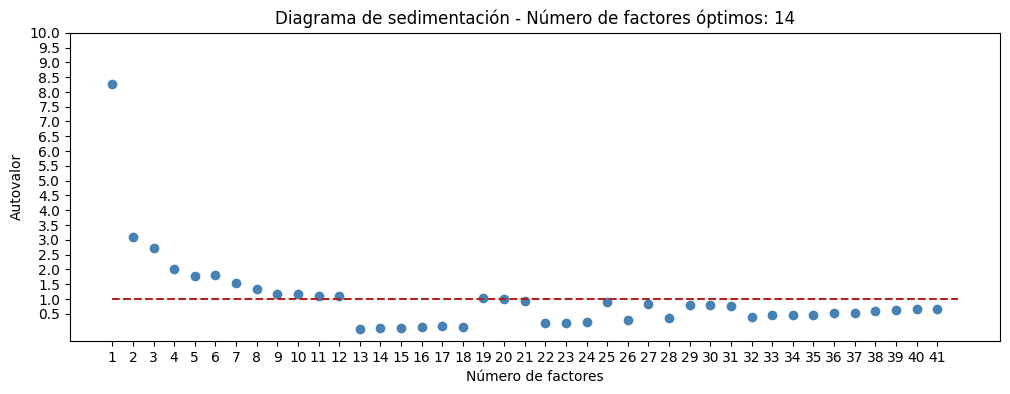

In [87]:
#@title Determinar el número de factores óptimos

# Fórmula para determinar el número de factores óptimos
display(Markdown("""
El valor de 1 en el criterio de Kaiser se utiliza como un punto de referencia o umbral para determinar la relevancia de los factores. Si el autovalor de un factor es mayor que 1, significa que ese factor explica más varianza que una sola variable observada, lo que sugiere que es relevante para retenerlo en el análisis. Si un autovalor es menor que 1, indica que ese factor explica menos varianza que una sola variable observada y, por lo tanto, puede no ser tan importante para retenerlo.
"""))

# Código para graficar el diagrama de sedimentación
autovalores, autovectores = np.linalg.eig(matrix_corr)

acumu = []
for i in autovalores:
    if i > 1:
        acumu.append(1)

n_factors = round(sum(acumu), 0)

x = range(1, len(autovalores) + 1)
y_ticks = np.arange(0.5, 10.1, 0.5)
plt.figure(figsize=(12, 4))
plt.scatter(x, autovalores, color="steelblue")
plt.hlines(1, 1, len(autovalores) + 1, color="firebrick", ls="--")
plt.title(f"Diagrama de sedimentación - Número de factores óptimos: {n_factors}")
plt.xlabel("Número de factores")
plt.ylabel("Autovalor")
plt.xticks(x)
plt.yticks(y_ticks)
plt.show()





El Análisis Factorial Exploratorio (AFE) es una técnica estadística utilizada para identificar patrones subyacentes entre un conjunto de variables observadas y reducir la dimensionalidad del conjunto de datos al extraer factores latentes que explican la estructura de correlación entre estas variables.

Esta técnica implica varios cálculos y técnicas, incluida la descomposición de la matriz de correlación entre las variables observadas para extraer los factores, seguida de la rotación de estos factores para mejorar su interpretación. La rotación varimax es una técnica comúnmente utilizada en AFE, que busca maximizar la varianza de las cargas factoriales dentro de cada factor y minimizar la varianza cruzada entre los factores.


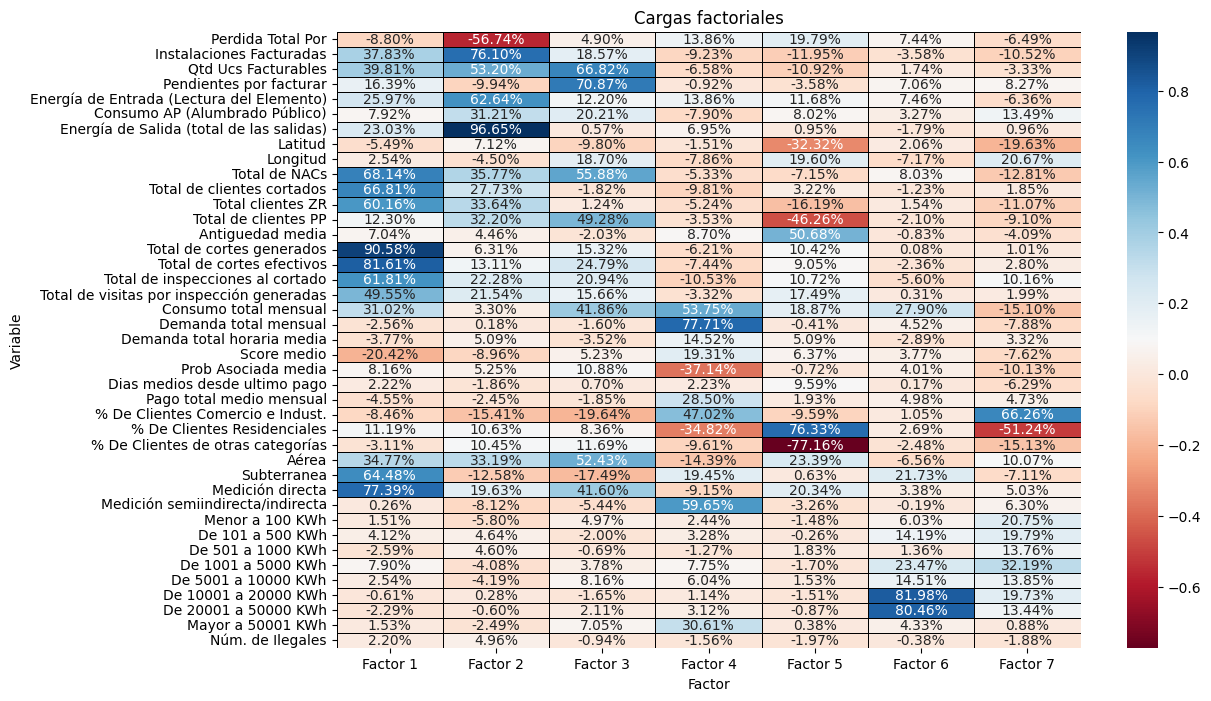

In [88]:
#@title Análisis factorial exploratorio (AFE)

# Descripción del análisis factorial exploratorio (AFE)
display(Markdown("""
El Análisis Factorial Exploratorio (AFE) es una técnica estadística utilizada para identificar patrones subyacentes entre un conjunto de variables observadas y reducir la dimensionalidad del conjunto de datos al extraer factores latentes que explican la estructura de correlación entre estas variables.

Esta técnica implica varios cálculos y técnicas, incluida la descomposición de la matriz de correlación entre las variables observadas para extraer los factores, seguida de la rotación de estos factores para mejorar su interpretación. La rotación varimax es una técnica comúnmente utilizada en AFE, que busca maximizar la varianza de las cargas factoriales dentro de cada factor y minimizar la varianza cruzada entre los factores.
"""))

# Código para realizar el Análisis Factorial Exploratorio (AFE) y visualizar las cargas factoriales
fa = FactorAnalyzer(n_factors=7, rotation="varimax")
fa.fit(new_df)

loadings = pd.DataFrame(
    fa.loadings_,
    index=new_df.columns,
    columns=[f"Factor {i}" for i in range(1, 8)]
)

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(loadings, cmap="RdBu", annot=True, fmt=".2%", linewidths=0.5, linecolor="k", ax=ax)
plt.title("Cargas factoriales")
plt.xlabel("Factor")
plt.ylabel("Variable")
plt.show()


In [89]:
#@title Interpretación de Factores Latentes

# display(Markdown("""
# 1. Factor de Consumo de Energía: Este factor está asociado principalmente con el consumo total y promedio de energía.

# 2. Factor de Entrada y Consumo Facturado: Este factor parece estar relacionado con la entrada de energía y el consumo registrado en las facturas.

# 3. Factor de Facturación e Infraestructura: Este factor está relacionado con aspectos de facturación y la infraestructura, como la cantidad de instalaciones facturadas y unidades facturables.

# 4. Factor de Demanda de Energía: Este factor está asociado con la demanda de energía, tanto en términos mensuales promedio como totales mensuales.

# 5. Factor de Gestión de Cortes: Este factor está relacionado con la gestión de cortes de energía, incluyendo la generación y efectividad de los cortes.

# 6. Factor de Ubicación Geoespacial: Este factor está asociado con la ubicación geoespacial de las instalaciones.

# 7. Factor de Gestión de Pagos y Puntuaciones: Este factor está asociado con la gestión de pagos y puntuaciones, como el pago total promedio mensual y el score promedio.

# 8. Factor de Antigüedad y Comportamiento de Pago: Este factor está relacionado con la antigüedad y el comportamiento de pago de los clientes.
# """))



El diagrama biplot es una visualización que muestra la relación entre las variables seleccionadas y los factores latentes obtenidos del análisis factorial. Aquí hay una descripción de los elementos del diagrama:

1. **Puntos de datos:** Cada punto en el gráfico representa una variable del conjunto de datos.
2. **Flechas rojas:** Las flechas indican la dirección y la fuerza de la relación entre las variables y los factores latentes. La longitud de la flecha representa la fuerza de la relación, mientras que la dirección indica la naturaleza de la relación (positiva o negativa).
3. **Ejes:** Los ejes del gráfico representan los factores latentes extraídos del análisis factorial.
4. **Interpretación:** La ubicación de las variables y las direcciones de las flechas proporcionan información sobre cómo se relacionan las variables con los factores latentes.
5. **Objetivo:** El biplot ayuda a comprender la estructura subyacente de los datos y cómo las variables contribuyen a los factores latentes identificados en el análisis factorial.


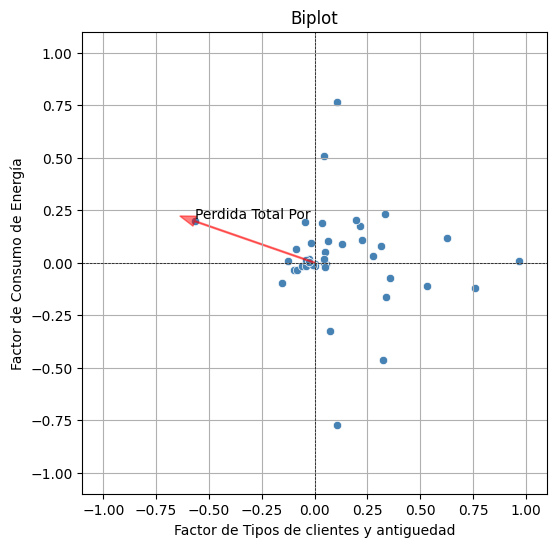

In [90]:
#@title Diagrama Biplot

# Explicación del Diagrama Biplot en Markdown
display(Markdown("""
El diagrama biplot es una visualización que muestra la relación entre las variables seleccionadas y los factores latentes obtenidos del análisis factorial. Aquí hay una descripción de los elementos del diagrama:

1. **Puntos de datos:** Cada punto en el gráfico representa una variable del conjunto de datos.
2. **Flechas rojas:** Las flechas indican la dirección y la fuerza de la relación entre las variables y los factores latentes. La longitud de la flecha representa la fuerza de la relación, mientras que la dirección indica la naturaleza de la relación (positiva o negativa).
3. **Ejes:** Los ejes del gráfico representan los factores latentes extraídos del análisis factorial.
4. **Interpretación:** La ubicación de las variables y las direcciones de las flechas proporcionan información sobre cómo se relacionan las variables con los factores latentes.
5. **Objetivo:** El biplot ayuda a comprender la estructura subyacente de los datos y cómo las variables contribuyen a los factores latentes identificados en el análisis factorial.
"""))

# Explicación de la fórmula de un biplot en Latex
# display(Latex(r"""
# \text{La fórmula para calcular las coordenadas de las flechas en un biplot es:} \\
# \text{Fórmula: } x = \text{Factor 8}, \ y = \text{Factor 1}
# """))

def calculate_arrow_coordinates(loadings, variables):
    arrow_coords = {}
    for variable in variables:
        factors = loadings.loc[variable]
        x = factors['Factor 2']
        y = factors['Factor 5']
        arrow_coords[variable] = (x, y)
    return arrow_coords

# Variables para las cuales se calcularán las coordenadas de las flechas
selected_variables = [
    "Perdida Total Por", # "Consumo Facturado", "Instalaciones Facturadas", "Score medio", "Antiguedad media", "Prob Asociada media"
]

# Obtener las coordenadas de las flechas para las variables seleccionadas
arrow_coordinates = calculate_arrow_coordinates(loadings, selected_variables)

# Generar el gráfico biplot
plt.figure(figsize=(6, 6))
sns.scatterplot(data=loadings, x='Factor 2', y='Factor 5', color='steelblue')

for variable, (x, y) in arrow_coordinates.items():  # Graficar flechas
    plt.arrow(0, 0, x, y, color='r', alpha=0.5, width=0.005, head_width=0.05, length_includes_head=False)
    plt.text(x, y, variable, fontsize=10, ha='left', va='bottom', rotation=0)

plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
plt.xlim((-1.1, 1.1))
plt.ylim((-1.1, 1.1))
plt.xlabel('Factor de Tipos de clientes y antiguedad')
plt.ylabel('Factor de Consumo de Energía')
plt.title('Biplot')
plt.grid(True)
plt.show()



In [91]:
#@title Comunalidad

# Obtención de las comunalidades
comunalidades = fa.get_communalities()

# Visualización de las comunalidades en un DataFrame
comunalidades_df = pd.DataFrame(comunalidades, index=new_df.columns, columns=["Comunalidad"])

# Explicación de la Comunalidad en Markdown
display(Markdown("""
La comunalidad en el análisis factorial exploratorio (AFE) representa la proporción de la varianza total de una variable que es explicada por los factores latentes extraídos durante el análisis.
En otras palabras, la comunalidad indica cuánto de la varianza de una variable es "común" a todos los factores latentes.
"""))

# Visualización de las comunalidades en un DataFrame
display(comunalidades_df)

# Comunalidad específica de la variable "Perdida Total Por"
comunalidad_perdida_total_por = comunalidades_df.loc["Perdida Total Por", "Comunalidad"]

# Explicación de la comunalidad específica en Markdown
display(Markdown(f"""
La comunalidad de la variable "Perdida Total Por" es de {comunalidad_perdida_total_por:.6f}.
Esta comunalidad indica la proporción de la varianza total de la variable que es explicada por los factores latentes extraídos durante el análisis factorial exploratorio (AFE).
En este caso, el valor de comunalidad de {comunalidad_perdida_total_por:.6f} sugiere que aproximadamente el {comunalidad_perdida_total_por * 100:.2f}% de la varianza de la variable "Perdida Total Por" es compartida o explicada por los factores latentes.
**Esto significa que la mayor parte de la varianza de esta variable no está siendo capturada por los factores latentes incluidos en el análisis factorial**.
"""))


La comunalidad en el análisis factorial exploratorio (AFE) representa la proporción de la varianza total de una variable que es explicada por los factores latentes extraídos durante el análisis.
En otras palabras, la comunalidad indica cuánto de la varianza de una variable es "común" a todos los factores latentes.


,Comunalidad
Perdida Total Por,0.400191
Instalaciones Facturadas,0.791814
Qtd Ucs Facturables,0.905661
Pendientes por facturar,0.552158
Energía de Entrada (Lectura del Elemento),0.517175
Consumo AP (Alumbrado Público),0.176452
Energía de Salida (total de las salidas),0.992520
Latitud,0.161359
Longitud,0.130110
Total de NACs,0.935309



La comunalidad de la variable "Perdida Total Por" es de 0.400191.
Esta comunalidad indica la proporción de la varianza total de la variable que es explicada por los factores latentes extraídos durante el análisis factorial exploratorio (AFE).
En este caso, el valor de comunalidad de 0.400191 sugiere que aproximadamente el 40.02% de la varianza de la variable "Perdida Total Por" es compartida o explicada por los factores latentes.
**Esto significa que la mayor parte de la varianza de esta variable no está siendo capturada por los factores latentes incluidos en el análisis factorial**.
